# Challenge classification of bearing

### Import libraries

In [23]:
#Data analysis libraries
import numpy as np 
import pandas as pd 

#Visulization and statistics libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from scipy import fftpack
import seaborn as sns
style.use('seaborn')

# Model preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

# Medel related libraries
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Reading the data

In [2]:
# Setting to display all columns
pd.set_option("Display.max_columns", None)

In [3]:
#To load the data 
target_set = pd.read_csv("assets/bearing_classes.csv", sep=";", skipinitialspace=True)
origin_set = pd.read_csv("assets/bearing_signals.csv", skipinitialspace=True)

In [36]:
# To check a shape of the dataframe
origin_set.shape

(10265700, 13)

In [37]:
# To see the first 10 row of the dataframe
origin_set.head(10)

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w
0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006
1,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243
2,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369
3,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520
4,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175
5,1,0,1,0.001667,-0.175320,-0.039563,-0.110275,0.191588,0.194450,0.255007,0.0,0.0,0.000520
6,1,0,1,0.002000,-0.175320,-0.039563,0.081789,0.097183,-0.189997,0.055715,0.0,0.0,0.000243
7,1,0,1,0.002333,0.113269,0.055072,-0.398371,0.097183,0.194450,0.454299,0.0,0.0,0.000697
8,1,0,1,0.002667,-0.367713,0.055072,-0.110275,0.191588,0.002226,-0.043930,0.0,0.0,0.000243
9,1,0,1,0.003000,-0.079124,0.055072,-0.206307,-0.091625,0.002226,0.454299,0.0,0.0,0.000070


In [38]:
# To check the info of the dataframe
origin_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10265700 entries, 0 to 10265699
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   experiment_id  int64  
 1   bearing_1_id   int64  
 2   bearing_2_id   int64  
 3   timestamp      float64
 4   a1_x           float64
 5   a1_y           float64
 6   a1_z           float64
 7   a2_x           float64
 8   a2_y           float64
 9   a2_z           float64
 10  rpm            float64
 11  hz             float64
 12  w              float64
dtypes: float64(10), int64(3)
memory usage: 1018.2 MB


### Some visualisation

#### To see the visualisation between bearing_a1 and timestamp

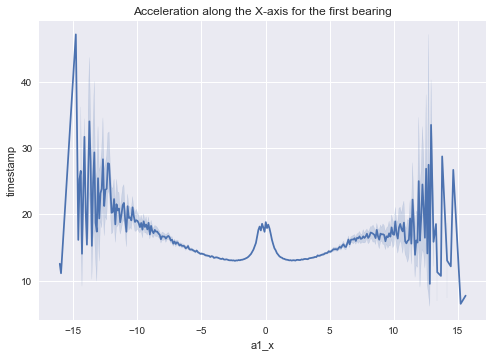

In [41]:
# To see the acceleration along the X-axis for the first bearing and timestamp
sns.lineplot(data = origin_set, x='a1_x', y='timestamp')
plt.title('Acceleration along the X-axis for the first bearing')
plt.show()

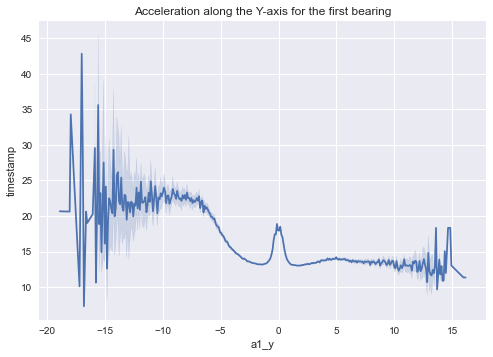

In [42]:
# To see the acceleration along the Y-axis for the first bearing and timestamp
sns.lineplot(data = origin_set, x='a1_y', y='timestamp')
plt.title('Acceleration along the Y-axis for the first bearing')
plt.show()

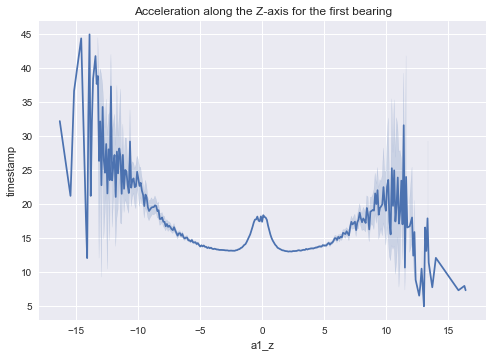

In [43]:
# To see the acceleration along the Z-axis for the first bearing and timestamp
sns.lineplot(data = origin_set, x='a1_z', y='timestamp')
plt.title('Acceleration along the Z-axis for the first bearing')
plt.show()

#### To see the visualisation between bearing_a2 and timestamp

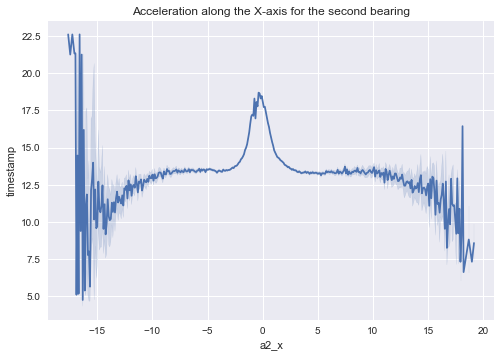

In [44]:
# To see the acceleration along the X-axis for the second bearing and timestamp
sns.lineplot(data = origin_set, x='a2_x', y='timestamp')
plt.title('Acceleration along the X-axis for the second bearing')
plt.show()

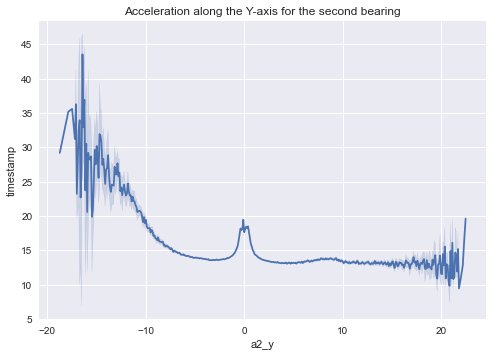

In [45]:
# To see the acceleration along the Y-axis for the second bearing and timestamp
sns.lineplot(data = origin_set, x='a2_y', y='timestamp')
plt.title('Acceleration along the Y-axis for the second bearing')
plt.show()

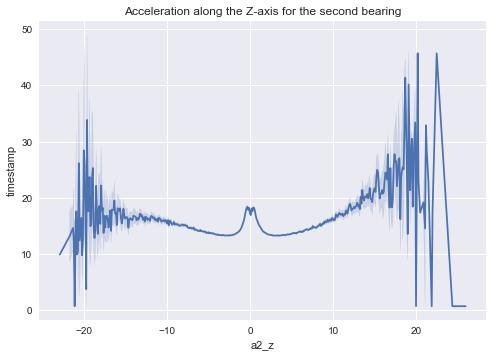

In [46]:
# To see the acceleration along the Z-axis for the second bearing and timestamp
sns.lineplot(data = origin_set, x='a2_z', y='timestamp')
plt.title('Acceleration along the Z-axis for the second bearing')
plt.show()

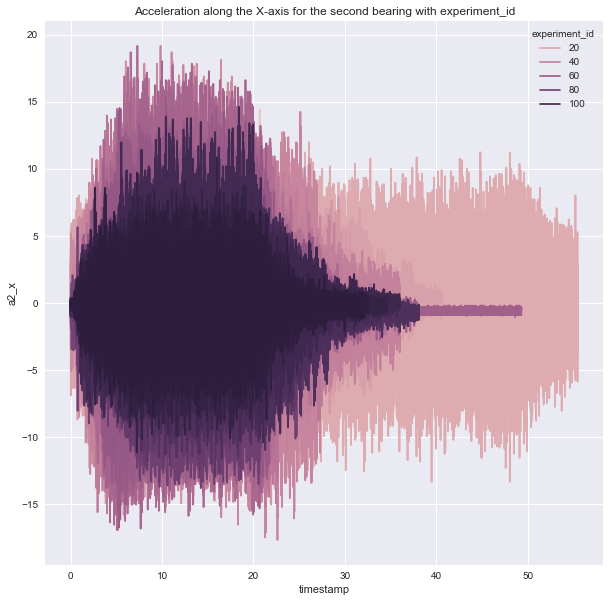

In [47]:
# To see the acceleration along the X-axis for the second bearing with experiment_id and timestamp
plt.figure(figsize = (10,10))
sns.lineplot(data = origin_set, x='timestamp', y='a2_x', hue = 'experiment_id')
plt.title('Acceleration along the X-axis for the second bearing with experiment_id')
plt.show()

### Feature engineering

In [48]:
# To rename the column name using function
"""This function takes dataframe & prefix of the columns.
   It needs name of columns from the dataframe and add prefix before the each name of the columns.
   It returns dataframe with new column names."""
def rename_column(df,prefix):
    column_name = list(df.columns)
    column_name = [prefix + name for name in column_name]
    return df.set_axis(column_name, axis=1)

In [49]:
# To drop some columns from the dataframe
df_train = origin_set.drop(['experiment_id','bearing_1_id'], axis=1)

In [50]:
# To see the column name of the dataframe
df_train.columns

Index(['bearing_2_id', 'timestamp', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y',
       'a2_z', 'rpm', 'hz', 'w'],
      dtype='object')

In [51]:
# To find maximun, minimum, mean, standerd deviation, median, range, kurtosis and skewness
# of the data and apply function for rename the column names for each features
max_set = df_train.groupby(['bearing_2_id']).max()
max_set = rename_column(max_set,"max_")
min_set = df_train.groupby(['bearing_2_id']).min()
min_set = rename_column(min_set,"min_")
mean_set = df_train.groupby(['bearing_2_id']).mean()
mean_set = rename_column(mean_set,"mean_")
std_set = df_train.groupby(['bearing_2_id']).std()
std_set = rename_column(std_set,"std_")
median_set = df_train.groupby(['bearing_2_id']).median()
median_set = rename_column(median_set,"median_")
range_set = df_train.groupby(['bearing_2_id']).max() - df_train.groupby(['bearing_2_id']).min()
range_set = rename_column(range_set,"range_")
kurtosis_set = df_train.groupby(['bearing_2_id']).apply(pd.DataFrame.kurtosis)
kurtosis_set = rename_column(kurtosis_set, 'kurtosis_')
skew_set = df_train.groupby(['bearing_2_id']).skew()
skew_set = rename_column(skew_set, 'skew_')

In [52]:
# To make dataframe of individual features and make list of new dataframe and list of new column names
df_bearing_1_x = df_train.drop(['a2_x','a2_y','a2_z','a1_y','a1_z'], axis = 1)
df_bearing_1_y = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_z'], axis = 1)
df_bearing_1_z = df_train.drop(['a2_x','a2_y','a2_z','a1_x','a1_y'], axis = 1)
df_bearing_2_x = df_train.drop(['a1_x','a1_y','a1_z','a2_y','a2_z'], axis = 1)
df_bearing_2_y = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_z'], axis = 1)
df_bearing_2_z = df_train.drop(['a1_x','a1_y','a1_z','a2_x','a2_y'], axis = 1)
bearing_feature = [df_bearing_1_x,df_bearing_1_y,df_bearing_1_z,df_bearing_2_x,df_bearing_2_y,df_bearing_2_z]
list_column = ['fft_a1_x','fft_a1_y','fft_a1_z','fft_a2_x','fft_a2_y','fft_a2_z']

In [53]:
# To find a frequency with the function
"""This function takes dataframe and number of bearing id.
   First create an empty list and apply a for loop with range of length of dataframe.
   Make a group as per bearing_2_id of dataframe.
   Find the frequency using the fftpack module of scipy library.
   Convert this frequency into absulate amplitude values.
   Function returns a list of all amplitude values of the freatures."""
def by_axis_bearing(bearing_feature, i):
    max_list = []
    for index in range(len(bearing_feature)):
        bearing_idx = bearing_feature[index]
        df_bearing = bearing_idx[bearing_idx['bearing_2_id'] == i]
        fft_values = fftpack.fft(df_bearing)
        max_amplitude = np.argmax(np.abs(fft_values))
        max_list.append(max_amplitude)
    return max_list

In [54]:
# To find the maximum frequency of each accelerations of bearings and make a dataframe
number_bearing = df_train['bearing_2_id'].max()

max_list = by_axis_bearing(bearing_feature, 1)
new_set = pd.DataFrame([max_list], columns=list_column,index=[1])

for i in range(2,number_bearing+1):
    max_list = by_axis_bearing(bearing_feature,i)
    temp_set = pd.DataFrame([max_list],columns=list_column,index=[i])
    new_set = new_set.append(temp_set)

In [55]:
# To concate a dataframe of all new features and change the index of target variables 
df = pd.concat([max_set, min_set, mean_set, std_set, median_set, range_set, kurtosis_set, skew_set, new_set], axis=1)
df['target']= target_set.iloc[1:,1]

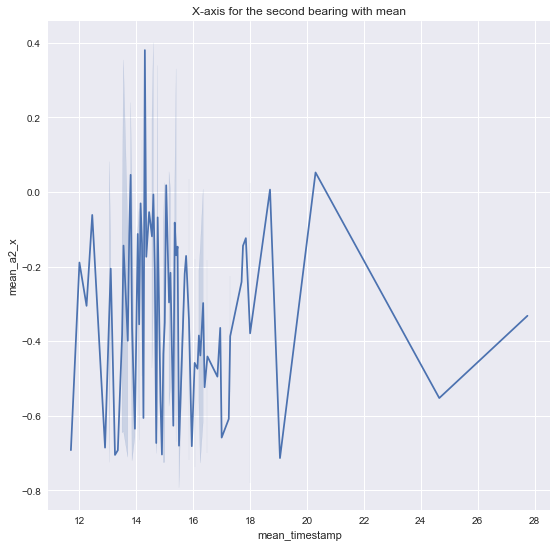

In [65]:
# To see the acceleration along the mean of X-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='mean_a2_x')
plt.title('X-axis for the second bearing with mean')
plt.show()

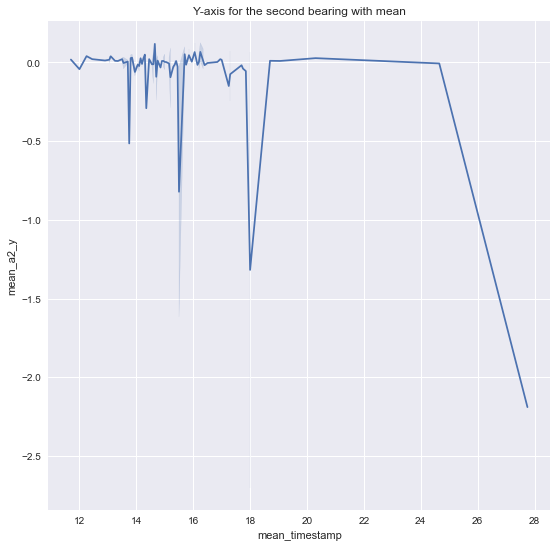

In [66]:
# To see the acceleration along the mean of Y-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='mean_a2_y')
plt.title('Y-axis for the second bearing with mean')
plt.show()

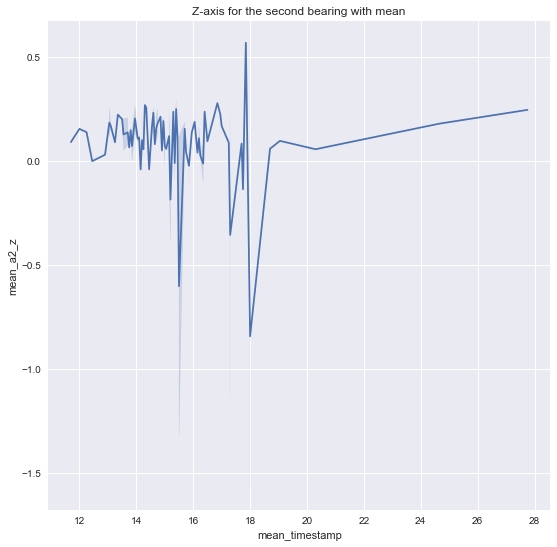

In [67]:
# To see the acceleration along the mean of Z-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='mean_a2_z')
plt.title('Z-axis for the second bearing with mean')
plt.show()

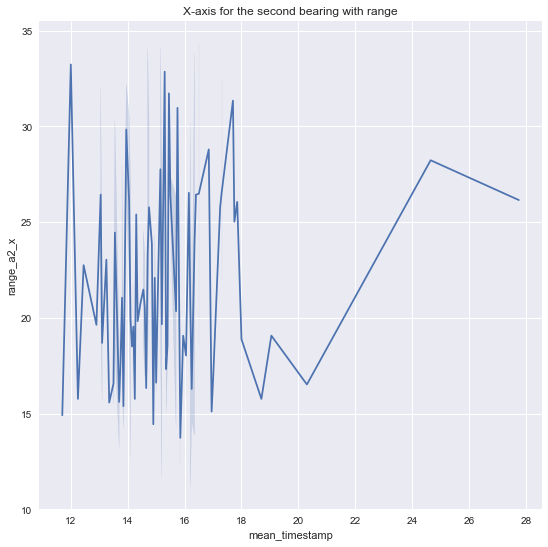

In [68]:
# To see the range of X-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='range_a2_x')
plt.title('X-axis for the second bearing with range')
plt.show()

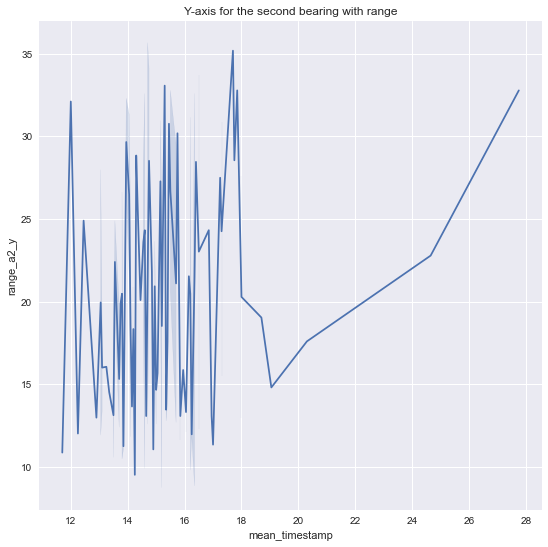

In [69]:
# To see the range of Y-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='range_a2_y')
plt.title('Y-axis for the second bearing with range')
plt.show()

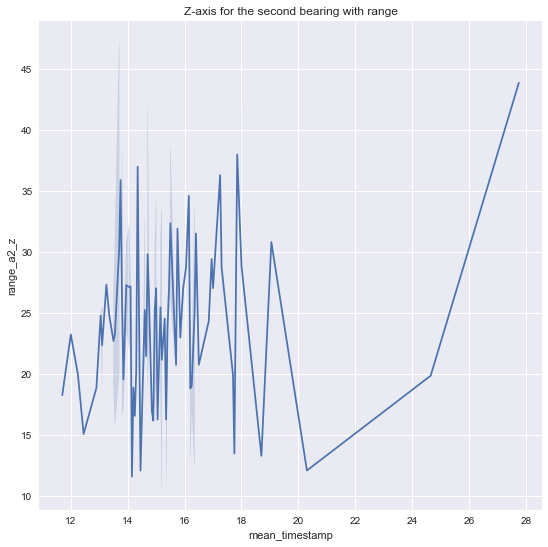

In [70]:
# To see the range of Z-axis for the second bearing and mean of timestamp
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_timestamp', y='range_a2_z')
plt.title('Z-axis for the second bearing with range')
plt.show()

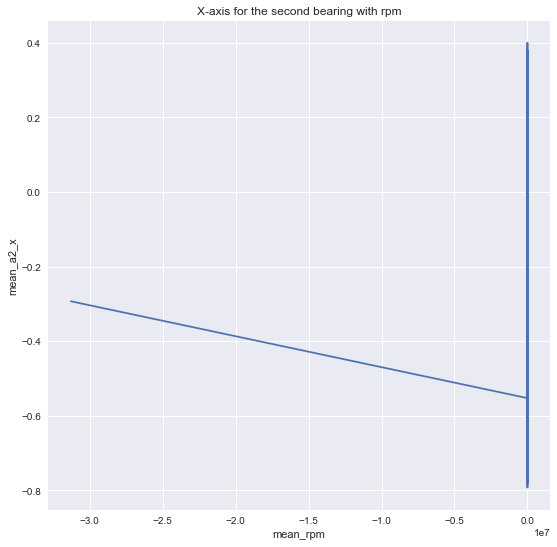

In [71]:
# To see the mean of X-axis for the second bearing and mean of rpm
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_rpm', y='mean_a2_x')
plt.title('X-axis for the second bearing with rpm')
plt.show()

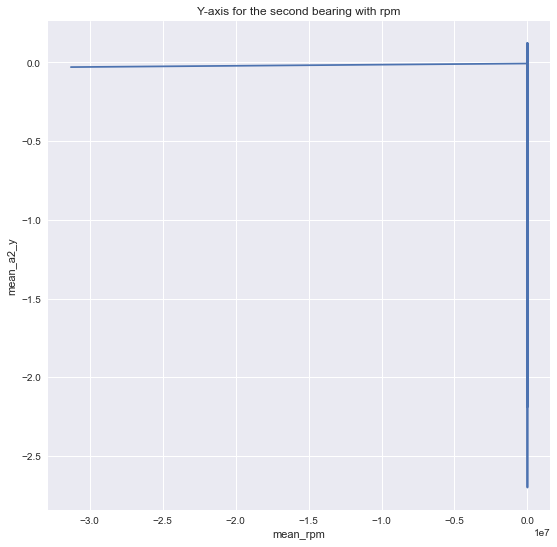

In [72]:
# To see the mean of Y-axis for the second bearing and mean of rpm
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_rpm', y='mean_a2_y')
plt.title('Y-axis for the second bearing with rpm')
plt.show()

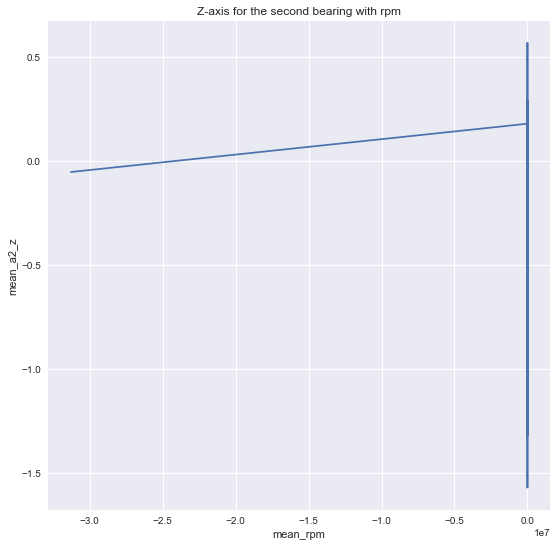

In [73]:
# To see the mean of Z-axis for the second bearing and mean of rpm
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_rpm', y='mean_a2_z')
plt.title('Z-axis for the second bearing with rpm')
plt.show()

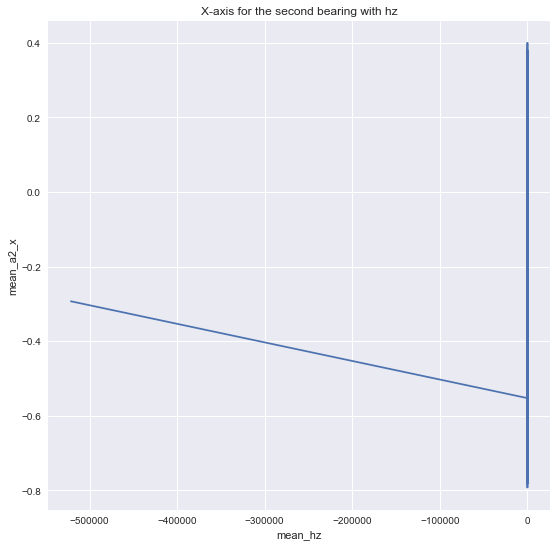

In [74]:
# To see the mean of X-axis for the second bearing and mean of hz
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_hz', y='mean_a2_x')
plt.title('X-axis for the second bearing with hz')
plt.show()

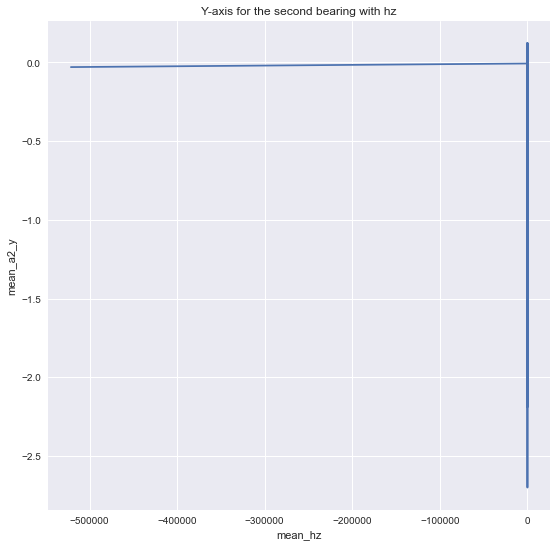

In [77]:
# To see the mean of Y-axis for the second bearing and mean of hz
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_hz', y='mean_a2_y')
plt.title('Y-axis for the second bearing with hz')
plt.show()

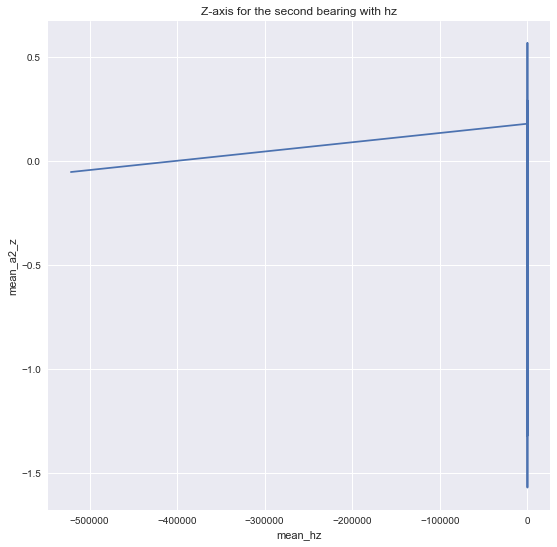

In [78]:
# To see the mean of Z-axis for the second bearing and mean of hz
plt.figure(figsize = (9,9))
sns.lineplot(data=df, x='mean_hz', y='mean_a2_z')
plt.title('Z-axis for the second bearing with hz')
plt.show()

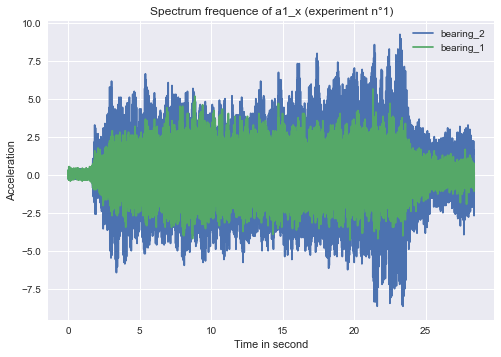

In [79]:
# To see the spectrum frequency of both bearings with experiment no 1
data = origin_set[origin_set['bearing_2_id'] == 1]
fig, ax = plt.subplots()
s1 = ax.plot(data['timestamp'], data['a2_y'], label="bearing_2")
s2 = ax.plot(data['timestamp'], data['a1_y'], label="bearing_1")
plot = [s1, s2]
plt.title("Spectrum frequence of a1_x (experiment n°1)")
plt.xlabel('Time in second')
plt.ylabel('Acceleration')
plt.legend(loc=1)
plt.show()

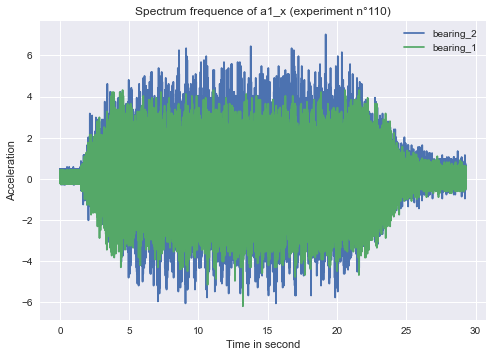

In [82]:
# To see the spectrum frequency of both bearings with experiment no 110
data = origin_set[origin_set['bearing_2_id'] == 110]
fig, ax = plt.subplots()
s1 = ax.plot(data['timestamp'], data['a2_y'], label="bearing_2")
s2 = ax.plot(data['timestamp'], data['a1_y'], label="bearing_1")
plot = [s1, s2]
plt.title("Spectrum frequence of a1_x (experiment n°110)")
plt.xlabel('Time in second')
plt.ylabel('Acceleration')
plt.legend(loc=1)
plt.show()

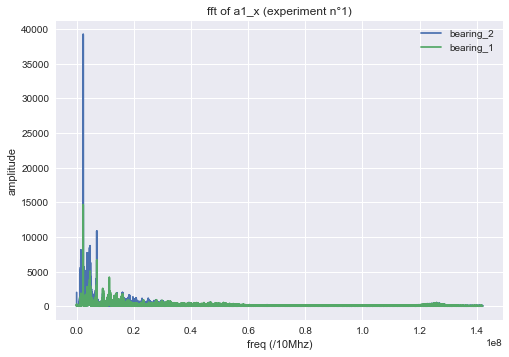

In [80]:
# To see the frequency with amplitude of both bearing
data = df_train[df_train['bearing_2_id'] == 1]['a1_y']
data2 = df_train[df_train['bearing_2_id'] == 1]['a2_y']

N = data.size # data size
T = 1.0 / (N*3333) # inverse of sampling rate
x = np.linspace(0.0, N*T, N)
y = data.values
yb = data2.values
yf = np.abs(fftpack.fft(y))
yfb = np.abs(fftpack.fft(yb))
xf = fftpack.fftfreq(data.size, d=T)

fig, ax = plt.subplots()
ax.plot(np.abs(xf), np.abs(yfb),label="bearing_2")
ax.plot(np.abs(xf), np.abs(yf),label="bearing_1")

plt.legend(loc=1)
plt.xlabel('freq (/10Mhz)')
plt.ylabel('amplitude')
plt.title("fft of a1_x (experiment n°1)")
plt.show()

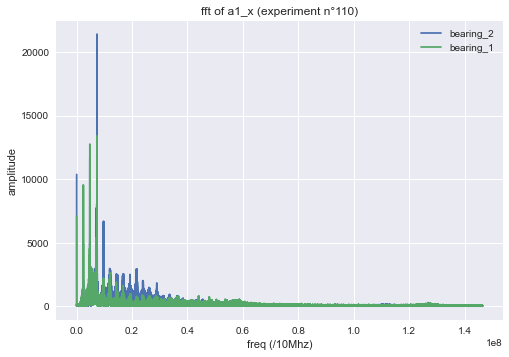

In [81]:
data = df_train[df_train['bearing_2_id'] == 110]['a1_y']
data2 = df_train[df_train['bearing_2_id'] == 110]['a2_y']

N = data.size # data size
T = 1.0 / (N*3333) # inverse of sampling rate
x = np.linspace(0.0, N*T, N)
y = data.values
yb = data2.values
yf = np.abs(fftpack.fft(y))
yfb = np.abs(fftpack.fft(yb))
xf = fftpack.fftfreq(data.size, d=T)

fig, ax = plt.subplots()
ax.plot(np.abs(xf), np.abs(yfb),label="bearing_2")
ax.plot(np.abs(xf), np.abs(yf),label="bearing_1")

plt.legend(loc=1)
plt.xlabel('freq (/10Mhz)')
plt.ylabel('amplitude')
plt.title("fft of a1_x (experiment n°110)")
plt.show()

In [56]:
df

,max_timestamp,max_a1_x,max_a1_y,max_a1_z,max_a2_x,max_a2_y,max_a2_z,max_rpm,max_hz,max_w,min_timestamp,min_a1_x,min_a1_y,min_a1_z,min_a2_x,min_a2_y,min_a2_z,min_rpm,min_hz,min_w,mean_timestamp,mean_a1_x,mean_a1_y,mean_a1_z,mean_a2_x,mean_a2_y,mean_a2_z,mean_rpm,mean_hz,mean_w,std_timestamp,std_a1_x,std_a1_y,std_a1_z,std_a2_x,std_a2_y,std_a2_z,std_rpm,std_hz,std_w,median_timestamp,median_a1_x,median_a1_y,median_a1_z,median_a2_x,median_a2_y,median_a2_z,median_rpm,median_hz,median_w,range_timestamp,range_a1_x,range_a1_y,range_a1_z,range_a2_x,range_a2_y,range_a2_z,range_rpm,range_hz,range_w,kurtosis_bearing_2_id,kurtosis_timestamp,kurtosis_a1_x,kurtosis_a1_y,kurtosis_a1_z,kurtosis_a2_x,kurtosis_a2_y,kurtosis_a2_z,kurtosis_rpm,kurtosis_hz,kurtosis_w,skew_timestamp,skew_a1_x,skew_a1_y,skew_a1_z,skew_a2_x,skew_a2_y,skew_a2_z,skew_rpm,skew_hz,skew_w,fft_a1_x,fft_a1_y,fft_a1_z,fft_a2_x,fft_a2_y,fft_a2_z,target
1,28.399667,7.327991,5.638507,9.204820,8.687975,9.228967,11.813929,1512.605042,25.210084,1.679266,0.0,-9.410165,-4.298115,-8.657115,-10.004077,-8.647843,-10.207810,0.0,0.0,0.000001,14.199833,-0.176971,-0.001740,-0.035361,0.114590,0.023329,0.250710,1082.423656,18.040394,0.419961,8.198422,1.748528,1.074788,1.689479,2.450624,2.243094,1.995330,495.807713,8.263462,0.323245,14.199833,-0.079124,0.055072,-0.014243,0.191588,0.002226,0.255007,1374.045802,22.900763,0.462081,28.399667,16.738155,9.936622,17.861935,18.692052,17.876810,22.021738,1512.605042,25.210084,1.679265,0.0,-1.2,0.803091,0.585030,1.416193,-0.207130,0.227841,0.887165,-0.679615,-0.679615,-0.905792,1.047415e-14,-0.162153,0.147986,-0.441701,-0.002391,0.066577,0.060053,-0.877610,-0.877610,0.238119,356922,357306,357534,357270,357294,357018,0
2,29.099667,7.424187,4.881431,8.340533,8.310358,8.748408,8.924198,1512.605042,25.210084,1.907451,0.0,-7.582435,-4.676653,-8.080924,-9.437651,-7.975060,-11.104623,0.0,0.0,0.000001,14.549833,-0.174032,-0.007636,-0.053353,-0.178986,0.024936,0.194061,1074.981634,17.916361,0.501160,8.400495,1.560411,0.944751,1.547722,2.192104,2.084081,1.683472,484.529563,8.075493,0.376274,14.549833,-0.175320,0.055072,-0.014243,-0.091625,0.098338,0.155361,1353.383459,22.556391,0.592651,29.099667,15.006622,9.558084,16.421456,17.748009,16.723468,20.028821,1512.605042,25.210084,1.907449,0.0,-1.2,0.956034,0.819961,0.892300,-0.097596,0.364910,1.315945,-1.114918,-1.114918,-1.265826,1.119378e-14,-0.171945,-0.050167,-0.228882,-0.156236,-0.188976,-0.071935,-0.697663,-0.697663,0.043088,351636,351762,351870,351462,351702,351372,0
3,26.199667,7.231794,5.449238,8.052437,9.632018,10.190086,7.927740,1512.605042,25.210084,2.132678,0.0,-8.352005,-4.108846,-8.369019,-12.080972,-8.455619,-11.204268,0.0,0.0,0.000001,13.099833,-0.172328,-0.002343,-0.039898,-0.121842,0.036149,0.183881,1149.927038,19.165451,0.513051,7.563337,1.640117,1.015238,1.592576,2.429144,2.294527,1.755556,445.825447,7.430424,0.344483,13.099833,-0.175320,0.055072,-0.014243,-0.091625,0.194450,0.155361,1428.571429,23.809524,0.581609,26.199667,15.583800,9.558084,16.421456,21.712990,18.645705,19.132008,1512.605042,25.210084,2.132677,0.0,-1.2,0.708640,0.555302,0.715607,-0.207138,0.340638,0.833997,-0.052822,-0.052822,-1.005156,1.018818e-14,-0.087350,0.011155,-0.202922,-0.061420,-0.232841,-0.064409,-1.103365,-1.103365,-0.038263,355812,355284,317148,339642,339882,355878,0
4,26.999667,5.981243,4.881431,8.148469,7.649527,7.883401,7.828094,1512.605042,25.210084,1.877711,0.0,-6.524276,-4.676653,-7.024573,-10.004077,-7.782836,-11.104623,0.0,0.0,0.000001,13.499833,-0.149644,-0.000549,-0.037679,-0.119574,0.030838,0.200699,1127.538630,18.792311,0.539426,7.794277,1.443702,0.952230,1.536901,2.298337,2.179757,1.736335,475.598609,7.926643,0.370396,13.499833,-0.079124,0.055072,-0.014243,-0.091625,0.002226,0.155361,1417.322835,23.622047,0.632119,26.999667,12.505518,9.558084,15.173042,17.653605,15.666237,18.932716,1512.605042,25.210084,1.877710,0.0,-1.2,0.634363,0.490713,1.026222,-0.386285,0.033154,0.779041,-0.141599,-0.141599,-1.15075

In [83]:
# To see the column names of the new dataframe with all new features
df.columns

Index(['max_timestamp', 'max_a1_x', 'max_a1_y', 'max_a1_z', 'max_a2_x',
       'max_a2_y', 'max_a2_z', 'max_rpm', 'max_hz', 'max_w', 'min_timestamp',
       'min_a1_x', 'min_a1_y', 'min_a1_z', 'min_a2_x', 'min_a2_y', 'min_a2_z',
       'min_rpm', 'min_hz', 'min_w', 'mean_timestamp', 'mean_a1_x',
       'mean_a1_y', 'mean_a1_z', 'mean_a2_x', 'mean_a2_y', 'mean_a2_z',
       'mean_rpm', 'mean_hz', 'mean_w', 'std_timestamp', 'std_a1_x',
       'std_a1_y', 'std_a1_z', 'std_a2_x', 'std_a2_y', 'std_a2_z', 'std_rpm',
       'std_hz', 'std_w', 'median_timestamp', 'median_a1_x', 'median_a1_y',
       'median_a1_z', 'median_a2_x', 'median_a2_y', 'median_a2_z',
       'median_rpm', 'median_hz', 'median_w', 'range_timestamp', 'range_a1_x',
       'range_a1_y', 'range_a1_z', 'range_a2_x', 'range_a2_y', 'range_a2_z',
       'range_rpm', 'range_hz', 'range_w', 'kurtosis_bearing_2_id',
       'kurtosis_timestamp', 'kurtosis_a1_x', 'kurtosis_a1_y', 'kurtosis_a1_z',
       'kurtosis_a2_x', 'kurtosis_a2_

In [89]:
#To drop some features from the dataframe
df1 = df.drop(['max_timestamp', 'max_a1_y', 'max_a1_z', 'max_a2_x', 'max_a2_x',
               'max_rpm', 'max_hz', 'max_w', 'min_timestamp', 'min_rpm',
               'min_hz', 'min_w', 'mean_timestamp', 'std_timestamp', 'std_a2_z',
               'std_rpm', 'std_hz', 'median_timestamp', 'median_a2_z',
               'range_timestamp', 'range_rpm', 'range_hz', 'range_w',
               'kurtosis_timestamp', 'kurtosis_bearing_2_id', 'skew_timestamp',
               'skew_rpm', 'fft_a1_x', 'fft_a1_y', 'fft_a2_x', 'fft_a1_z'], axis=1)

In [90]:
# To identify dependent variable(y) and independent variables(X)
X = df1.drop(['target'], axis=1)
y = df1['target']

In [91]:
# To split the dataframe into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [92]:
# To check the R-squared using Statistical model of OLS regression

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.869
Model:                            OLS   Adj. R-squared (uncentered):              0.759
Method:                 Least Squares   F-statistic:                              7.914
Date:                Tue, 03 Aug 2021   Prob (F-statistic):                    1.28e-13
Time:                        15:59:38   Log-Likelihood:                          79.861
No. Observations:                 112   AIC:                                     -57.72
Df Residuals:                      61   BIC:                                      80.92
Df Model:                          51                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [93]:
# To check the score using Linear regression model
lnreg = LinearRegression()
lnreg.fit(X_train, y_train)
y_pred_lnreg = lnreg.predict(X_test)

scores_lnreg = cross_val_score(lnreg, X_train, y_train, cv=5)
print(f"The Cross validation score of Linear regression model : ", '\n', scores_lnreg)
print(f"The Mean of Linear regression model : ", scores_lnreg.mean())
print(f"The Standard Deviation of Linear regression model :", scores_lnreg.std())
# print("Average 5-Fold CV Score: {}".format(np.mean(scores_lnreg)))

The Cross validation score of Linear regression model :  
 [-5.16077367e+09  0.00000000e+00  6.64700782e-01  0.00000000e+00
  5.27150056e-01]
The Mean of Linear regression model :  -1032154734.5573393
The Standard Deviation of Linear regression model : 2064309469.710604


In [94]:
# To check the score using Random Forest classification model 

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_random_forest = rf.predict(X_test)
accuracy_random_forest = round(accuracy_score(y_test, y_pred_random_forest) * 100, 2)
print(f"The accuracy of RandomForest Model is : ", str(accuracy_random_forest) + '%')
print(f"The Cross Validation Report : ", '\n', (classification_report(y_test, y_pred_random_forest)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_random_forest))
scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model :", '\n', scores_rf)
print(f"The Mean of Random Forest model :", scores_rf.mean())
print(f"The Standard Deviation of Random Forest model :", scores_rf.std())

The accuracy of RandomForest Model is :  91.3%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.50      0.67         4

    accuracy                           0.91        23
   macro avg       0.95      0.75      0.81        23
weighted avg       0.92      0.91      0.90        23

The confusion matrix :  
 [[19  0]
 [ 2  2]]
The Cross validation score of Random Forest model : 
 [1.         0.94444444 1.         0.94444444 1.        ]
The Mean of Random Forest model : 0.9777777777777779
The Standard Deviation of Random Forest model : 0.027216552697590882


In [95]:
# To check the score using Random Forest classification model using GridSearchCV
param_grid = {
    'n_estimators':[200,150,100,50],
    'criterion':['gini','entropy'],
    'max_depth':[2,4,6,8]
    }

Model_rf = RandomForestClassifier(random_state=41)
grid = GridSearchCV(estimator=Model_rf, param_grid=param_grid, cv=5, n_jobs=None)
grid.fit(X_train, y_train)
Model_rf = grid.best_estimator_
y_pred_train = Model_rf.predict(X_test)
training_data_accuracy_rf = round(accuracy_score(y_test, y_pred_train) * 100, 2)
print(f"The accuracy of RandomForestC Model is : ", str(training_data_accuracy_rf) + '%')
print(f"The Cross Validation Rapport : ",'\n', (classification_report(y_test, y_pred_train)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_train))
scores_grid_rf = cross_val_score(Model_rf, X_train, y_train, cv=5, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model : ", '\n', scores_grid_rf)
print(f"The Mean of Random Forest model : ", scores_grid_rf.mean())
print(f"The Standard Deviation of Random Forest model : ", scores_grid_rf.std())

The accuracy of RandomForestC Model is :  91.3%
The Cross Validation Rapport :  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.50      0.67         4

    accuracy                           0.91        23
   macro avg       0.95      0.75      0.81        23
weighted avg       0.92      0.91      0.90        23

The confusion matrix :  
 [[19  0]
 [ 2  2]]
The Cross validation score of Random Forest model :  
 [1.         0.94444444 1.         0.94444444 1.        ]
The Mean of Random Forest model :  0.9777777777777779
The Standard Deviation of Random Forest model :  0.027216552697590882


In [96]:
# To check the score using Random Forest classification model using hyperperameter: entropy and max_depth = 6
rf_entropy = RandomForestClassifier(criterion='entropy', max_depth=6)
rf_entropy.fit(X_train, y_train)
y_pred_rf_entropy = rf_entropy.predict(X_test)
accuracy_score_entropy = round(accuracy_score(y_test, y_pred_rf_entropy) * 100, 2)
print(f"The accuracy of RandomForestC Model with entropy is : ", str(accuracy_score_entropy) + '%')
y_train_pred_entropy = rf_entropy.predict(X_train)
accuracy_score_train_entropy = round(accuracy_score(y_train, y_train_pred_entropy) * 100, 2)
print(f"The accuracy of train set using RandomForestC Model with entropy is : ", str(accuracy_score_train_entropy) + '%')
scores_rf_entropy = cross_val_score(rf_entropy, X_train, y_train, cv=5, scoring = "accuracy")
print(f"The Cross validation score of Random Forest model with entropy : ", '\n', scores_rf_entropy)
print(f"The Mean of Random Forest model with  entropy : ", scores_rf_entropy.mean())
print(f"The Standard Deviation of Random Forest model with  entropy : ", scores_rf_entropy.std())
print(f"Variation : ", scores_rf_entropy.var())

The accuracy of RandomForestC Model with entropy is :  91.3%
The accuracy of train set using RandomForestC Model with entropy is :  100.0%
The Cross validation score of Random Forest model with entropy :  
 [1.         0.94444444 1.         0.94444444 1.        ]
The Mean of Random Forest model with  entropy :  0.9777777777777779
The Standard Deviation of Random Forest model with  entropy :  0.027216552697590882
Variation :  0.0007407407407407415


<AxesSubplot:xlabel='feature'>

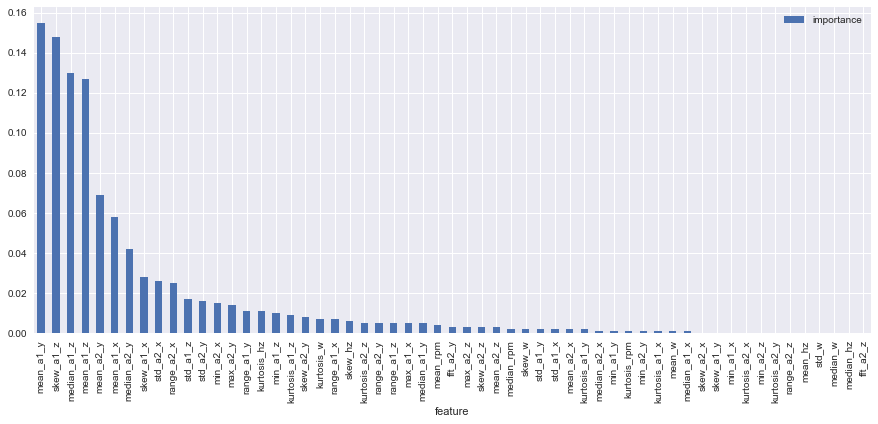

In [97]:
# To check the importance of all feature of Random Forest calssification model
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(rf.feature_importances_, 3)})
importances1 = importances.sort_values('importance', ascending=False).set_index('feature')
importances1.plot(kind='bar', figsize=(15,6))

In [98]:
# To check the score using Support Vector classification model 

svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = round(accuracy_score(y_test, y_pred_svc) * 100, 2)
print(f"The accuracy of SVC Model is : ", str(accuracy_svc) + '%')
print(f"The Cross Validation Report : ", '\n', (classification_report(y_test, y_pred_svc)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_svc))
scores_svc = cross_val_score(svc, X_train, y_train, cv=5, scoring = "accuracy")
print(f"The Cross validation score of SVC Model : ", '\n', scores_svc)
print(f"The Mean of SVC Model : ", scores_svc.mean())
print(f"The Standard Deviation of SVC Model : ", scores_svc.std())

The accuracy of SVC Model is :  82.61%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.00      0.00      0.00         4

    accuracy                           0.83        23
   macro avg       0.41      0.50      0.45        23
weighted avg       0.68      0.83      0.75        23

The confusion matrix :  
 [[19  0]
 [ 4  0]]
The Cross validation score of SVC Model :  
 [0.94444444 0.88888889 0.88888889 0.88888889 0.94117647]
The Mean of SVC Model :  0.9104575163398693
The Standard Deviation of SVC Model :  0.026436272439420514


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
# To check the score using KNN classification model 

knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = round(accuracy_score(y_test, y_pred_knn) * 100, 2)
print(f'The accuracy of KNN Model is : ', str(accuracy_knn) + '%')
print('The Cross Validation Report : ','\n', (classification_report(y_test, y_pred_knn)))
print(f"The confusion matrix : ", '\n', confusion_matrix(y_test, y_pred_knn))
scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring = "accuracy")
print(f"The Cross validation score of KNN Model :", '\n', scores_knn)
print(f"The Mean of KNN Model :", scores_knn.mean())
print(f"The Standard Deviation of KNN Model :", scores_knn.std())

The accuracy of KNN Model is :  82.61%
The Cross Validation Report :  
               precision    recall  f1-score   support

           0       0.83      1.00      0.90        19
           1       0.00      0.00      0.00         4

    accuracy                           0.83        23
   macro avg       0.41      0.50      0.45        23
weighted avg       0.68      0.83      0.75        23

The confusion matrix :  
 [[19  0]
 [ 4  0]]
The Cross validation score of KNN Model : 
 [0.94444444 0.88888889 0.88888889 0.88888889 0.94117647]
The Mean of KNN Model : 0.9104575163398693
The Standard Deviation of KNN Model : 0.026436272439420514


C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sadhana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
